# Linear model for the minimum-variance control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

## Definition
For the linear models of the eye and arm, we consider a single-input single-output discrete-time system under control with the following state-update equation:
$$
\tilde{x}_{t+1} = A\tilde{x}_t+B\left (u_t+w_t \right)
$$  
where $\tilde{x}_t$ is the $n$-dimentional state at time $t$, $u_t$ the neural driving signal at time $t$, $w_t$ is a white noise with mean zero and variance $ku_t^2$, $A$ is a fixed $n \times n$ matrix and B is a $n \times 1$ vector both describing the dynamics of the system.

In [3]:
beta = 1
m = 10
A = np.array([[1., 1.],[0., 1-beta/m]])
B = np.array([0., 1/m])
k = 0.000005

TODO : use dt / begin with bang bang solution

TODO :  copy the notebook 

TODO: put all functions in one script HW.py - use OO a bit like https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py#L9 - then just use the functions

TODO: cache data https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py#L161 , just plot

TODO: explore parameters


TODO: apply on aSPEM / generalized coordinates / include delays

In [379]:
dt = 0.0025
t_T = .05
t_R = .05
T = int(t_T/dt)
R = int(t_R/dt)
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.array([0., 0.])
xT = np.array([10., 0.])

## Mean and covariance matrix
$\tilde{x}_t = A\tilde{x}_{t-1}+B\left (u_{t-1}+w_{t-1} \right) \\
\tilde{x}_t = A \left (A\tilde{x}_{t-2}+B\left (u_{t-2}+w_{t-2} \right)\right) + B\left (u_{t-1}+w_{t-1} \right) \\
...\\
\tilde{x}_t = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}B \left (u_i+w_i \right)}
$
  
We deduce the mean:
$E\left [\tilde{x}_t \right] = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}Bu_i}$ since $E\left [w_t \right] = 0$.


Then, $cov\left [\tilde{x}_t\right ] = \sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T E\left [w_t^2 \right]} = k\sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T u_t^2}$


In [380]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))
        # mod = n % 2
        # return power(A, mod).dot(power(A,(n-mod)//2))

In [381]:
def A_pow(A):
    A_pow_array = np.zeros((T+R+1,2,2))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

In [382]:
A_pow_array = A_pow(A)

In [383]:
def pow_fast(n):
    return A_pow_array[n]

In [384]:
ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

In [385]:
ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]

In [386]:
ci = np.array([ci0_array,ci1_array])

In [12]:
%%timeit
power(A, T+R)

5.47 µs ± 4.97 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
%%timeit
pow_fast(T+R)

336 ns ± 0.253 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [279]:
utest = np.ones(T+R+1)
utest[T-1:T] *= -2
utest[T:(T+R+1)] = 0

In [46]:
def expectation(u, t):
    if t == 0:
        return x0
    else:
        somme =  pow_fast(t).dot(x0)
        for i in np.arange(t):
            ci0 = ci0_array[t-i-1]
            ci1 = ci1_array[t-i-1]
            #mat = power(A, t-i-1) @ B
            somme += np.array([ci0, ci1])*u[i]
        return somme

In [97]:
def expectation2(u, t):
    if t == 0:
        return x0
    else:
        somme =  pow_fast(t).dot(x0)
        somme += sum(np.transpose(ci[:,0:t]*np.flipud(u[0:t])))
        return somme

In [17]:
%%timeit
expectation(utest, T)

64.5 µs ± 2.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%%timeit
expectation2(utest, T)

28.6 µs ± 147 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
def variance(u, t):
    somme0 = 0.
    somme1 = 0.
    for i in np.arange(t):
        ci0 = ci0_array[t-i-1]
        ci1 = ci1_array[t-i-1]
        somme0 += (m**2)*k*(ci0**2)*(u[i]**2)
        somme1 += (m**2)*k*(ci1**2)*(u[i]**2)
    return np.array([somme0,somme1])

In [105]:
def variance2(u, t):
    somme = np.array([(m**2)*k*sum(np.flipud(ci0_array[0:t]*ci0_array[0:t])*u[0:t]*u[0:t]),(m**2)*k*sum(np.flipud(ci1_array[0:t]*ci1_array[0:t])*u[0:t]*u[0:t])])
    return somme

In [21]:
%%timeit
variance(utest, T)

81.1 µs ± 636 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
%%timeit
variance2(utest, T)

28.3 µs ± 3.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


  
## Minimum-variance problem
Here, the problem we consider consists in minimizing the sum of the variance of the position after reaching the target. Let $V_t$ be the top-left value in the covariance matrix at time $t$. Then, we want to minimize $\sum \limits_{t=T+1}^{T+R}V_t +bias$. 

In [23]:
def bias(u, t):
    mean = expectation(u, t)
    result = (mean-xT)**2
    return result

In [106]:
def bias2(u, t):
    mean = expectation2(u, t)
    result = (mean-xT)**2
    return result

 
This can be formulated as a quadratic programming problem, which we solved using a gradient descent.

## Gradient descent

Let $\mathcal{C}$ be the cost function to minimize.  
That is, we want to find $\textbf{u}_{\textbf{opt}} = \underset{u_0, ..., u_{T+R}}{argmin} \left (\sum \limits_{t=T+1}^{T+R}V_t  + \sum \limits_{t=T}^{T+R}\left [ \left (E\left [x_t\right] - x_T \right )^2 + \left (E\left [\dot{x}_t\right] \right )^2 \right ] \right) = \underset{u_0, ..., u_{T+R}}{argmin}\left(\mathscr{C}\left (\textbf{u}\right)\right)$.



TODO: utiliser un $\lambda$ pour moduler le coût en vitesse (ou est-ce qu'il s'absorbe dans la variance??)

In [25]:
def cost(u):
    somme = 0
    for t in (T+1+np.arange(R)):
        var = variance(u, t)
        bia = bias(u, t)
        somme += var[0] + bia[0] + bia[1]
    somme += bias(u,T)[0] + bias(u,T)[1]
    return somme

In [26]:
def cost2(u):
    somme = 0
    for t in (T+1+np.arange(R)):
        var = variance2(u, t)
        bia = bias2(u, t)
        somme += var[0] + bia[0] + bia[1]
    somme += bias2(u,T)[0] + bias2(u,T)[1]
    return somme

In [27]:
def cost3(u):
    return sum(variance2(u, t)[0] + sum(bias2(u, t)) for t in (T+1+np.arange(R))) + sum(bias2(u,T))

In [28]:
def cost4(u):
    return np.sum(variance2(u, t)[0] + sum(bias2(u, t)) for t in (T+1+np.arange(R))) + sum(bias2(u,T))

In [29]:
%%timeit
cost(utest)

2.18 ms ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%%timeit
cost2(utest)

787 µs ± 679 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [31]:
%%timeit
cost3(utest)

774 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%%timeit
cost4(utest)

768 µs ± 679 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


First, we start with a random $\textbf{u}$ which values are in $\left [-5, 5 \right]$.  
We assume that the control signal is zero during the post-movement period.

Iterating the following process, we will get the right $\textbf{u}_{\textbf{opt}}$ :  
$\forall i \in \left \{ 0, ..., T+R-1 \right \} : u_i = u_i - \eta \times \frac{\partial \mathscr{C}\left(\textbf{u}\right)}{\partial u_i}$

We compute the derivative of the cost function and there are several cases.  
  
If $i < T:$ $\dfrac{\partial \mathscr{C}\left(\textbf{u}\right)}{\partial u_i} = 2k u_i \sum \limits_{t=T+1}^{T+R}{c_{i,t}^0}^2 + 2 \sum \limits_{t=T}^{T+R}{\left [c_{i,t}^0\left (E\left [x_t\right] - x_T \right ) + c_{i,t}^1 E\left [\dot{x}_t\right]\right]}$  
  
  
Else if $i = T:$ $\dfrac{\partial \mathscr{C}\left(\textbf{u}\right)}{\partial u_T} = 2k u_T \sum \limits_{t=T+1}^{T+R}{c_{T,t}^0}^2 + 2 \sum \limits_{t=T+1}^{T+R}{\left [c_{T,t}^0\left (E\left [x_t\right] - x_T \right ) + c_{T,t}^1 E\left [\dot{x}_t\right]\right]}$  
  
  
Else if $T < i < T+R:$ $\dfrac{\partial \mathscr{C}\left(\textbf{u}\right)}{\partial u_i} = 2k u_i \sum \limits_{t=i+1}^{T+R}{c_{i,t}^0}^2 + 2 \sum \limits_{t=i+1}^{T+R}{\left [c_{i,t}^0\left (E\left [x_t\right] - x_T \right ) + c_{i,t}^1 E\left [\dot{x}_t\right]\right]}$  
  
  
  
where $\forall t \in \{T, .., T+R-1\}, \forall i \in \{0, .., t-1\}: A^{t-1-i}B = \begin{pmatrix}
c_{i,t}^0\\ 
c_{i,t}^1
\end{pmatrix}$

TODO: montrer que c'est linéaire en $x_T$

In [33]:
def cost_deriv(u, i): # Derivative of the cost function with respect to u_i
    ci0_2 = 0
    somme = 0
    for t in (T+1+np.arange(R)):
        if i < t:
            ci0 = ci0_array[t-i-1] # to keep only the position term in the n x 1 vector
            somme += 2*ci0*((expectation(u, t))[0]-xT[0]) # bias term
            ci0_2 += ci0**2
    somme += 2*(m**2)*k*u[i]*ci0_2 + 2*ci0_array[T-i-1]*((expectation(u, T))[0]-xT[0])# variance term
    return somme

In [107]:
def cost_deriv2(u, i): # Derivative of the cost function with respect to u_i
    if i < T:
        return sum(sum(2*np.transpose(ci[:,(T-i-1):(T+R-i)])*([expectation2(u,t).tolist() for t in (T+np.arange(R+1))]-xT))) + 2*(m**2)*k*u[i]*sum(ci0_array[(T+1-i-1):(T+R-i)]**2) # variance term
    elif i == T:
        return sum(sum(2*np.transpose(ci[:,0:R])*([expectation2(u,t).tolist() for t in (T+1+np.arange(R))]-xT))) + 2*(m**2)*k*u[T]*sum(ci0_array[0:R]**2)
    else:
        return sum(sum(2*np.transpose(ci[:,0:(T+R-i)])*([expectation2(u,t).tolist() for t in (i+1+np.arange(R+T-i))]-xT))) + 2*(m**2)*k*u[i]*sum(ci0_array[0:(T+R-i)]**2) # variance term

In [282]:
%%timeit
cost_deriv(utest,0)

3.43 ms ± 4.78 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [280]:
%%timeit
cost_deriv2(utest,0)

1.23 ms ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We choose the number of iterations of the process and the stepsize $\eta$ of the gradient descent.

In [393]:
niter = 10000
eta = 0.003

In [403]:
#np.random.seed(42)
#u = np.random.uniform(-5, 5, T+R+1)
#u[T:T+R+1]=0
#u = 0.5 * np.ones(T+R+1)
#u[(T-1):T] *= -2
#u[T:(T+R+1)] = 0
a = np.zeros((niter+1, T+R+1)) # To save the evolution of the values of u at each iteration
a[0, :] = u.copy()
for i_iter in np.arange(niter):
    u_old = u.copy()
    u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv2(u_old, i) for i in np.arange(T+R)])
    a[i_iter+1, :] = u.copy()


Then, we draw $\text{u}$, that is, the evolution of the control signal during the experiment.

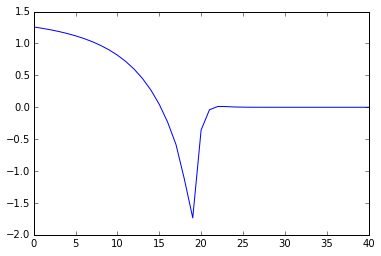

In [404]:
plt.plot(u)

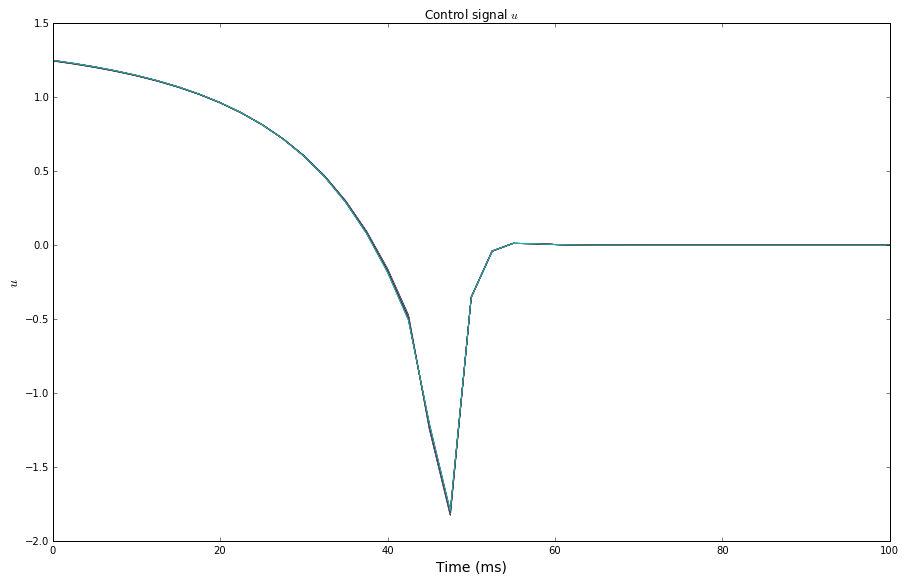

In [395]:
plot_signal(a, 1000, 10000, 0.05, 0.05, 0.0025)

In [53]:
position = np.zeros((niter+1,T+R+1))
velocity = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        mean = expectation2(a[i,:], j)
        position[i,j] = mean[0]
        velocity[i,j] = mean[1]

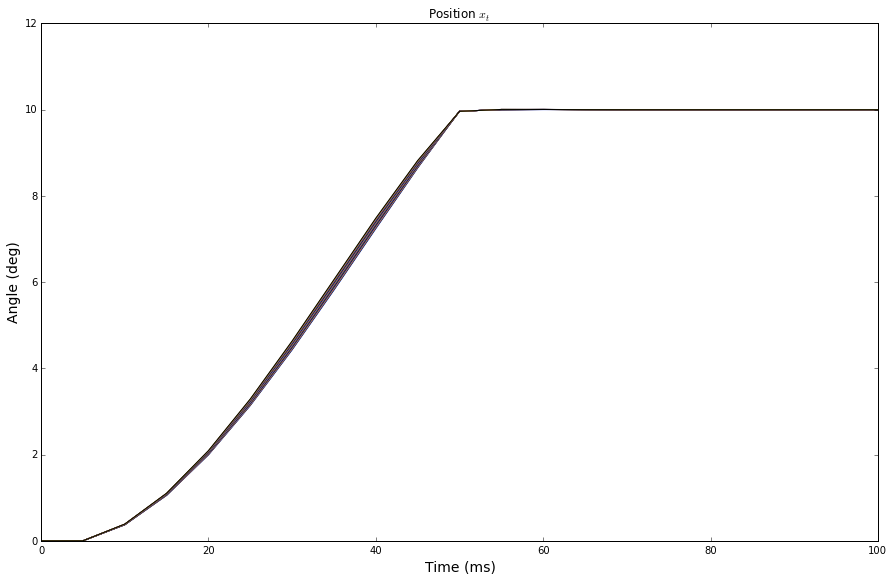

In [56]:
plot_position(position, 500, 10000, 0.05, 0.05, 0.005)

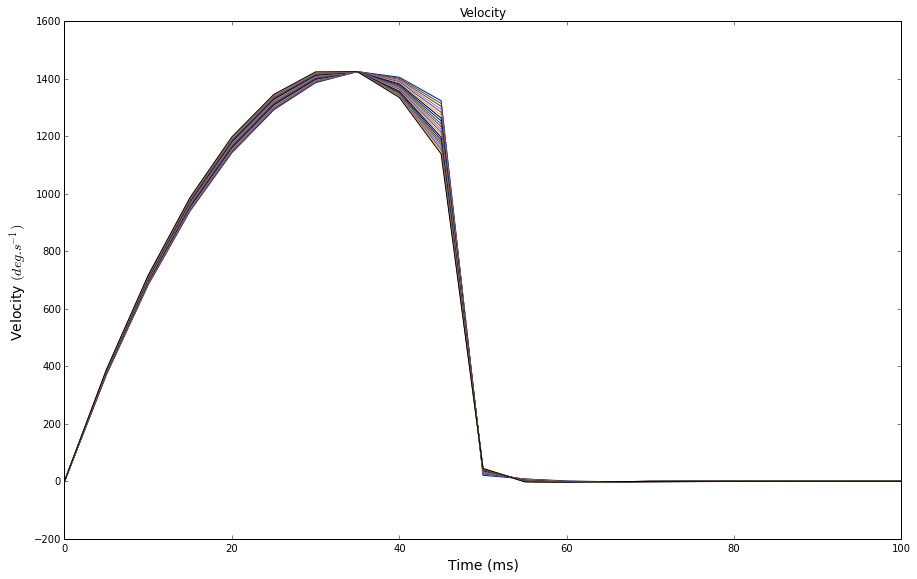

In [57]:
plot_velocity(velocity, 500, 10000, 0.05, 0.05, 0.005)

In [44]:
variance = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        variance[i,j] = (variance2(a[i,:], j))[0]

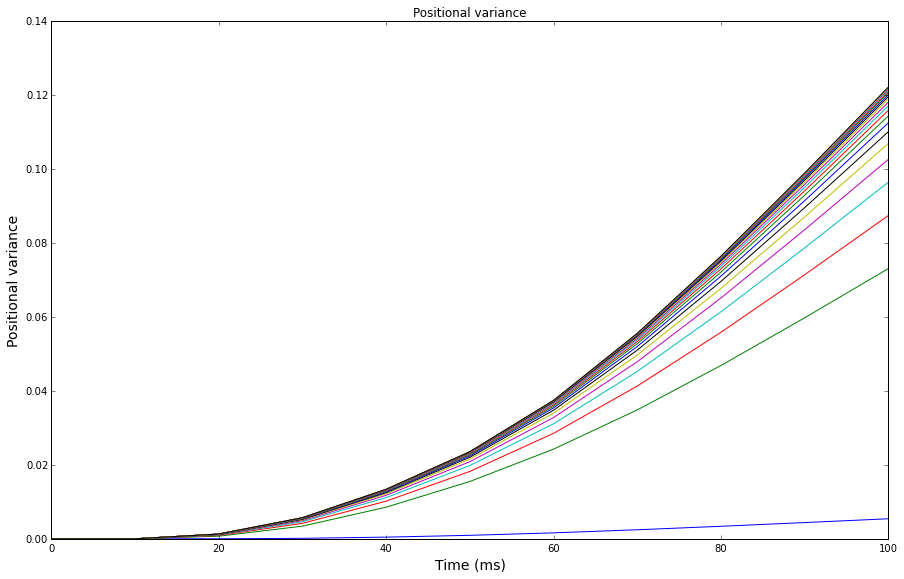

In [45]:
plot_variance(variance, 500, 10000, 0.05, 0.05, 0.01)

In [46]:
cost_p = np.zeros(niter+1)

for i in np.arange(niter+1):
    cost_p[i] = cost3(a[i])

(-10, 450)

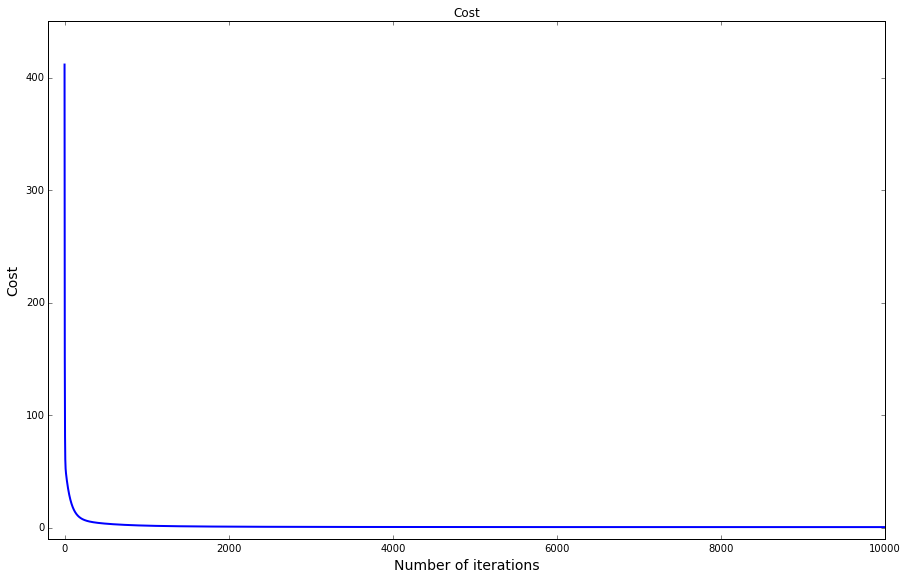

In [51]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(np.arange(niter+1), cost_p, '-', lw = 2)
ax.set_title('Cost')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)
ax.set_xlim(-200, niter+1)
ax.set_ylim(-10, 450)


Finally, we trace the position at time T for each iteration.

In [52]:
positionT = np.zeros(niter+1)

for i in np.arange(niter+1):
    positionT[i] = (expectation2(a[i], T))[0]

(0, 11)

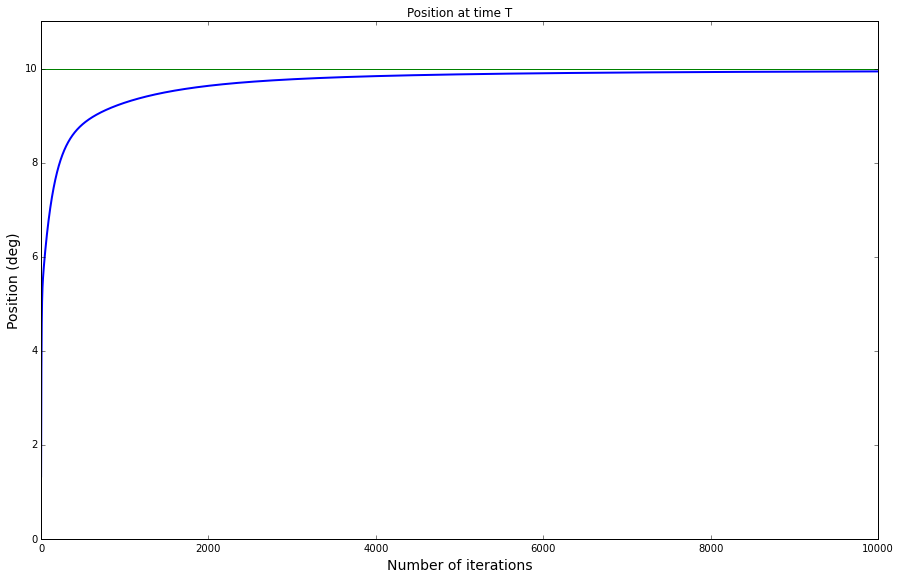

In [56]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(np.arange(niter+1), positionT, '-', lw=2)
ax.set_title('Position at time T')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Position (deg)', fontsize=14)
ax.plot([0,niter],[10,10])
ax.set_ylim(0, 11)

## Comparison with the bangbang control

First, we try to find the best $U_+$ and $U_-$ parameters that enable to reach the target at time $T$ by a bangbang control.

In [57]:
rhoT = int(0.43*(T+R))

In [58]:
rhoT

4

In [97]:
u_bangbang = np.zeros(T+R+1)
u_old = u_bangbang.copy()
index = 0
prev_sum = sum([sum((expectation2(u_old,t)-xT)**2) for t in T+np.arange(R+1)])
for i in np.arange(2000):
    for j in np.arange(2000):
        u_bangbang[0:rhoT] = 11.04+i/100000
        u_bangbang[rhoT:T] = -34.19-j/100000
        index = 2000*i+j
        val = sum([sum((expectation2(u_bangbang,t)-xT)**2) for t in T+np.arange(R+1)])
        if val < prev_sum:
            u_old = u_bangbang.copy()
            prev_sum = val

In [95]:
index

3999999

In [98]:
u_old

array([ 11.05094,  11.05094,  11.05094,  11.05094, -34.20375,   0.     ,
         0.     ,   0.     ,   0.     ,   0.     ,   0.     ])

In [99]:
u_bangbang = np.zeros(T+R+1)

for i in np.arange(rhoT):
    u_bangbang[i] = 11.05094

u_bangbang[rhoT] = -34.20375

In [104]:
expectation2(u_bangbang,T+R)

array([  1.00000015e+01,   8.49951306e-07])

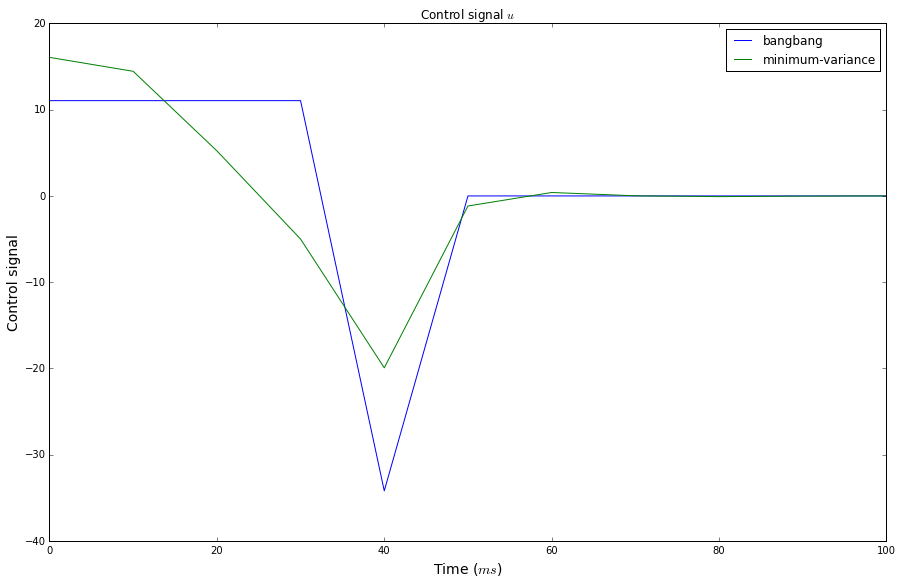

In [105]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms,u_bangbang,label="bangbang")
ax.plot(time_ms,u,label="minimum-variance")
ax.set_title(r'Control signal $u$')
ax.set_xlabel(r'Time ($ms$)', fontsize=14)
ax.set_ylabel('Control signal', fontsize=14)
ax.legend()

In [111]:
var_bangbang = np.zeros(T+R+1)
for i in np.arange(T+R+1):
    var_bangbang[i] = (variance2(u_bangbang, i))[0]

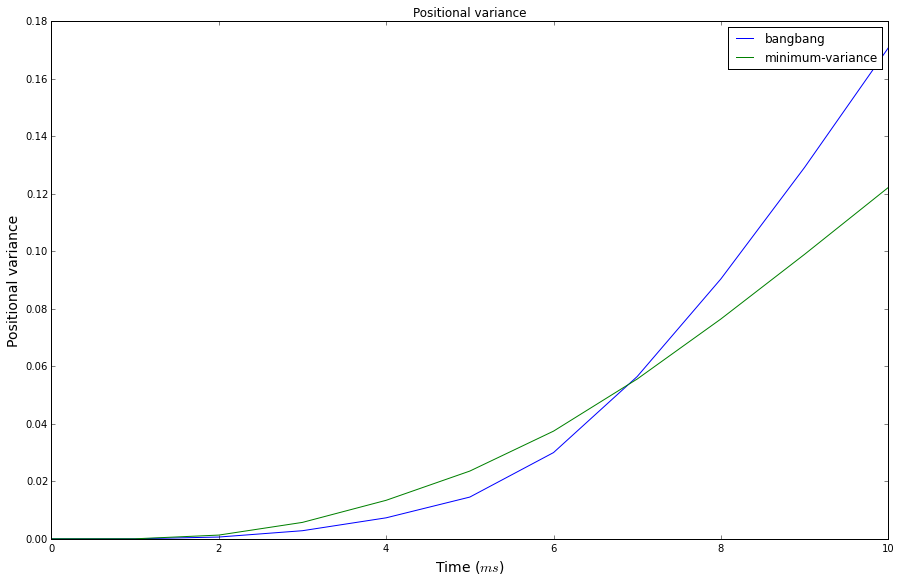

In [112]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(var_bangbang,label="bangbang")
ax.plot(variance[niter,:],label="minimum-variance")
ax.set_title('Positional variance')
ax.set_xlabel(r'Time ($ms$)', fontsize=14)
ax.set_ylabel('Positional variance', fontsize=14)
ax.legend()

TODO: essayer en rajoutant le biais

In [113]:
pos_bangbang = np.zeros(T+R+1)
vel_bangbang = np.zeros(T+R+1)
for i in np.arange(T+R+1):
    pos_bangbang[i] = expectation2(u_bangbang,i)[0]
    vel_bangbang[i] = expectation2(u_bangbang,i)[1]

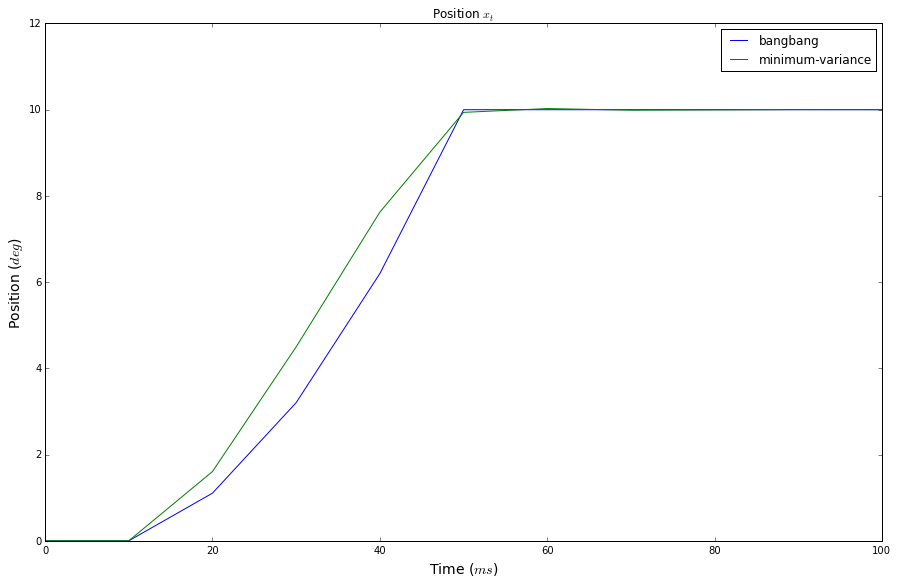

In [114]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms,pos_bangbang,label="bangbang")
ax.plot(time_ms,position[niter,:],label="minimum-variance")
ax.set_title(r'Position $x_t$')
ax.set_xlabel(r'Time ($ms$)', fontsize=14)
ax.set_ylabel(r'Position ($deg$)', fontsize=14)
ax.legend()

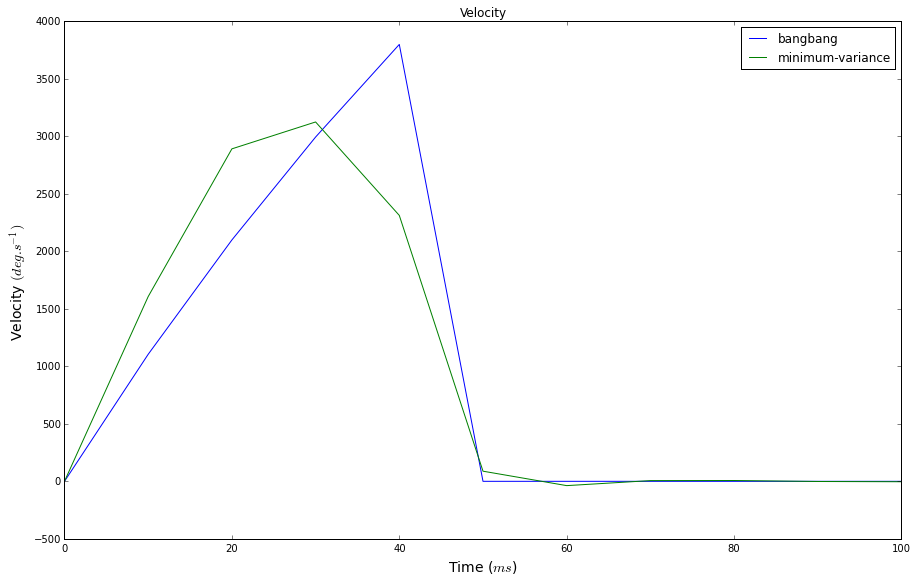

In [115]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms,1000*vel_bangbang,label="bangbang")
ax.plot(time_ms,1000*velocity[niter,:],label="minimum-variance")
ax.set_title('Velocity')
ax.set_xlabel(r'Time ($ms$)', fontsize=14)
ax.set_ylabel(r'Velocity $(deg.s^{-1})$ ', fontsize=14)
ax.legend()